In [1]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy import sparse

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

### $ \frac{\partial p}{\partial t} = - \frac{\partial}{\partial x} [ \mu(x,t) p(x,t) ] + \frac{\partial^2}{\partial x^2} [ D(x,t) p(x,t) ]$

In [8]:
class FP_diffusion:
    
    def __init__(self, X, dx2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
               
class FP_drift:
    
    def __init__(self, X, dx):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
    
class FokkerPlanck_1D:
    
    def __init__(self, X, mu, D, spatial_order=4):
      
        self.X = X
        p = self.X.field_list[0]
        self.domain = p.domain
        
        dx = FiniteDifferenceUniformGrid(1, spatial_order, p*mu)
        dx2 = FiniteDifferenceUniformGrid(2, spatial_order, p*D)
        
        self.operators = [FP_drift(X, dx),
                          FP_diffusion(X, dx2)] 
            
        self.ts_list   = [CrankNicolson(self.operators[0],axis=0),
                          CrankNicolson(self.operators[1],axis=0)]     
        
        self.t = 0.
        self.iter = 0
        
    def step(self, dt):

        self.ts_list[1].step(dt)
        self.ts_list[0].step(dt)
        #self.ts_list[0].step(dt/2.)
        self.t += dt
        self.iter += 1

In [11]:
resolution = 50
alpha = .1
spatial_order = 4

grid = field.UniformPeriodicGrid(resolution,2*np.pi)
domain = field.Domain([grid])
x = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])
r = np.array([x])-np.pi
IC = np.exp(-r**2*8)
p.data[:]=IC
gamma=0.5
#mu = field.Array(domain,0.5*np.ones(p.data.shape))
D = field.Array(domain,0.1*np.ones(p.data.shape))

mu= field.Array(domain,domain.grids[0].values*(gamma))

new = mu*p
new_field = new.operate()
#print('new shape = ', np.shape(new.data))
print(p.data.shape)

print("N = ", [domain.grids[0].N]*2)
print("p shape", np.shape([p.data]))
test_matrix = sparse.diags([p.data], [0], shape=[domain.grids[0].N]*2)
diff = FokkerPlanck_1D(X,mu,D)

tmax = 1-1e-5

dt = alpha * grid.dx

while diff.t < tmax:
    diff.step(dt)

(50,)
N =  [50, 50]
p shape (1, 50)


/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


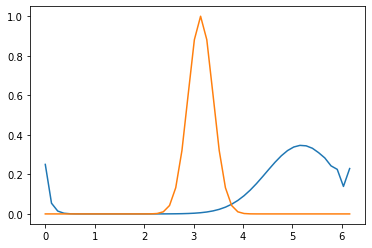

In [12]:
plt.plot(x[0],p.data)
plt.plot(x[0],IC[0][0])

In [44]:
print(domain.__dict__)

{'dimension': 1, 'grids': [<field.UniformPeriodicGrid object at 0x7f111f542e80>], 'shape': [200]}


In [45]:
print(domain.grids[0].values)

[0.         0.03141593 0.06283185 0.09424778 0.12566371 0.15707963
 0.18849556 0.21991149 0.25132741 0.28274334 0.31415927 0.34557519
 0.37699112 0.40840704 0.43982297 0.4712389  0.50265482 0.53407075
 0.56548668 0.5969026  0.62831853 0.65973446 0.69115038 0.72256631
 0.75398224 0.78539816 0.81681409 0.84823002 0.87964594 0.91106187
 0.9424778  0.97389372 1.00530965 1.03672558 1.0681415  1.09955743
 1.13097336 1.16238928 1.19380521 1.22522113 1.25663706 1.28805299
 1.31946891 1.35088484 1.38230077 1.41371669 1.44513262 1.47654855
 1.50796447 1.5393804  1.57079633 1.60221225 1.63362818 1.66504411
 1.69646003 1.72787596 1.75929189 1.79070781 1.82212374 1.85353967
 1.88495559 1.91637152 1.94778745 1.97920337 2.0106193  2.04203522
 2.07345115 2.10486708 2.136283   2.16769893 2.19911486 2.23053078
 2.26194671 2.29336264 2.32477856 2.35619449 2.38761042 2.41902634
 2.45044227 2.4818582  2.51327412 2.54469005 2.57610598 2.6075219
 2.63893783 2.67035376 2.70176968 2.73318561 2.76460154 2.79601

In [2]:
class FP_diffusion_2D:
    
    def __init__(self, X, dx2, dy2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 - dy2
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = [dx2+dy2]
               
class FP_drift_2D:
    
    def __init__(self, X, dx, dy):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx + dy
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = []
        #self.F_ops = [-dx - dy]
    

    
class FokkerPlanck_2D:
    
    def __init__(self, X, mu, D, spatial_order=4):
      
        self.X = X
        p = self.X.field_list[0]
        self.domain = p.domain
        print(type(mu),type(FiniteDifferenceUniformGrid(1, spatial_order, p, axis=0)))
        dx = mu*FiniteDifferenceUniformGrid(1, spatial_order, p, axis=0)
        dx2 = D*FiniteDifferenceUniformGrid(2, spatial_order, p, axis=0)
        dy = mu*FiniteDifferenceUniformGrid(1, spatial_order, p, axis=1)
        dy2 = D*FiniteDifferenceUniformGrid(2, spatial_order, p, axis=1)
        
        #self.operators = [FP_drift_2D(X, dx, dy),
        #                  FP_diffusion_2D(X, dx2, dy2)] 
        
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx + dy - dx2 - dy2
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        self.ts = CrankNicolson(self,axis='full')
        
        self.t = 0.
        self.iter = 0
        
    def step(self, dt):

        self.ts.step(dt)
        self.t += dt
        self.iter += 1

In [3]:
resolution = 50
alpha = .1
spatial_order = 4

grid_x = field.UniformPeriodicGrid(resolution,2*np.pi)
grid_y = field.UniformPeriodicGrid(resolution,2*np.pi)
domain = field.Domain((grid_x, grid_y))


x, y = domain.values()
#print(np.shape(x[0]))

p = field.Field(domain)
X = field.FieldSystem([p])
r = x-np.pi
IC = np.exp(-r**2*8)
p.data[:]=IC
gamma=0.5
mu = field.Array(domain,0.5*np.ones(p.data.shape))
D = field.Array(domain,0.1*np.ones(p.data.shape))


gamma *= np.ones(resolution)
mu = field.Array(domain,domain.grids[0].values[:,None]*(gamma))




diff = FokkerPlanck_2D(X,mu,D)

tmax = 1-1e-5

dt = alpha * domain.grids[0].dx

while diff.t < tmax:
    diff.step(dt)
    
# matrix shape is =  (200, 200) matrix sig =  [1, 0] array shape is =  (200,) arr_sig =  [0] out_sig =  [1]

/home/nkaaz/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<class 'field.Array'> <class 'spatial.FiniteDifferenceUniformGrid'>


(50,) (50,)


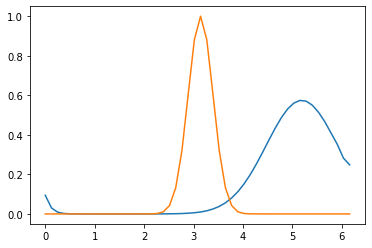

In [4]:
print(np.shape(x[:,0]), np.shape(p.data[:,0]))
plt.plot(x[:,0],p.data[:,5])
plt.plot(x[:,0],IC[:,0])

In [13]:
test_matrix = np.ones((50,50,2500))
flattened_data = np.ones((2500))
new = test_matrix @ flattened_data
print(np.shape(new))
print(new)
print(test_matrix)

(50, 50)
[[2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 ...
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]]
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. .

In [24]:

twoD_array = np.ones((50,50))*2.

print(twoD_array)
twoD_array_flat = twoD_array.reshape(np.prod(twoD_array.shape))
print(twoD_array_flat.shape, twoD_array_flat)

#print([50]*2)
test_matrix_sparse = sparse.diags([twoD_array_flat], [0], shape=[2500, 2500])
#test_matrix = test_matrix_sparse.A

#test_matrix_reshaped = test_matrix.reshape((50,50,2500))
print(test_matrix_reshaped)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
(2500,) [2. 2. 2. ... 2. 2. 2.]
[[[2. 0. 0. ... 0. 0. 0.]
  [0. 2. 0. ... 0. 0. 0.]
  [0. 0. 2. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ..